# About descriptives_of_log_data

This notebook computes some basic descriptive statistics of the log data such as determining the fraction of students that use different sim components (record,table,graph,restore,...)

In [1]:
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 20, 7
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

## Who and how much?
### First we pull the latest parsing report for each sim. 
If there are several and no date is provided, we pull the latest one.

In [2]:
def find_latest_parsing_report_file(sim, date=None, infolder=FOLDER):
    if date:
        for root, dirs, files in os.walk(infolder):
            for f in files:
                if sim in f and "report" in f and date in f:
                    print "Captured {0} parsing report from the date {1}".format(sim,date)
                    return os.path.join(root, f)
        print "No file found for {0} sim and on date {1}.".format(sim,date)
    else:
        report_dates = []
        for root, dirs, files in os.walk(infolder):
            for f in files:
                if sim in f and "report" in f:
                    report_dates.append(os.path.join(root, f).split('on=')[1].replace('.txt',''))
        dates = [datetime.datetime.strptime(d, '%Y-%m-%d_%H.%M.%S') for d in report_dates]
        dates.sort()
        sorteddates = [datetime.datetime.strftime(ts, '%Y-%m-%d_%H.%M.%S') for ts in dates]
        if sorteddates:
            return find_latest_parsing_report_file(sim, date=sorteddates[-1], infolder=infolder)
        else:
            print "No file found for {0} sim.".format(sim)

In [3]:
beers_report_file = find_latest_parsing_report_file('beers')
caps_report_file = find_latest_parsing_report_file('caps')
df_beers = pd.read_table(beers_report_file, sep='\t')
df_caps = pd.read_table(caps_report_file, sep='\t')

Captured beers parsing report from the date 2017-10-17_14.13.04
Captured caps parsing report from the date 2017-10-13_10.44.47


In [4]:
ids_beers = list(df_beers['studentid'].apply(str))
ids_caps = list(df_caps['studentid'].apply(str))
all_ids = ids_beers + ids_caps
print "There are {0} beers, {1} caps, for a total of {2} unique student ids.".format(len(set(ids_beers)),len(set(ids_caps)),len(set(all_ids)))

There are 177 beers, 170 caps, for a total of 180 unique student ids.


### Let's clean up the ids a little
First let's evaluate how many log files we have per id. Hopefully, most ids have two log files, a beers and a caps log file. We remove duplicates (students who did both sims) and see what's left. Of those, most will be ids used for testing but some of them will be from PhET crashing.

In [5]:
ids_by_count = {}
for i in set(all_ids):
    count = all_ids.count(i)
    if count not in ids_by_count.keys():
        ids_by_count[count] = [i]
    else:
        ids_by_count[count].append(i)

for c,ids in ids_by_count.iteritems():
    print "There are {0} ids with {1} log file: {2}".format(len(ids),c,', '.join(sorted([str(i) for i in ids])))

There are 8 ids with 1 log file: 12344564, 12344567, 12345567, 12345667, 12357888, 12456456, 13493169, 36107164
There are 154 ids with 2 log file: 10105157, 10127163, 10192168, 10232160, 10375163, 10420167, 10537160, 10561164, 10708152, 10908162, 10970160, 11095146, 11200165, 11326321, 11384795, 11394167, 11612162, 11691167, 11777163, 11892169, 11929166, 11997159, 12017165, 12238164, 12263156, 12288167, 12302161, 12329163, 12341234, 12344675, 12406161, 12665164, 12707161, 12818156, 12907149, 13122150, 13134165, 13140165, 13193166, 13228164, 13310139, 13407169, 13624169, 13654167, 13660166, 13726167, 13870641, 13945160, 13981167, 14002169, 14055131, 14088168, 14201151, 14261165, 14293162, 14302168, 14565169, 14805169, 14828163, 15026512, 15055169, 15072160, 15160164, 15188167, 15298166, 15317162, 15444164, 15457134, 15482152, 15496161, 15554169, 15677161, 15884161, 16136159, 16237162, 16328144, 16606167, 16618163, 16657165, 16752165, 16901162, 16961152, 17007153, 17018157, 17036164, 170

Now let's check that those with 2 log files have one for each sim.

In [6]:
beers_only, caps_only, both_sims = [],[],[]
for i in ids_by_count[2]:
    if i in ids_beers and i not in ids_caps: beers_only.append(i)
    elif i not in ids_beers and i in ids_caps: caps_only.append(i)
    elif i in ids_beers and i in ids_caps: both_sims.append(i)
print "Of all the ids with two logs, {0} have two beers logs, {1} has two caps logs, and {2} have one of each.".format(len(beers_only), len(caps_only), len(both_sims))

Of all the ids with two logs, 2 have two beers logs, 1 has two caps logs, and 151 have one of each.


## Some basic stats our select students
Once we clean up our student ids, (matching with survey ids and finding students who used different ids for both sims), we can update these stats.
### How often is each component used?

In [7]:
df_b = df_beers[df_beers['studentid'].apply(str).isin(both_sims)]
df_c = df_caps[df_caps['studentid'].apply(str).isin(both_sims)]

In [8]:
print "Of the {0} students:".format(len(both_sims))
print "\t action:\t beers | caps"
print "\t record data:\t {0} | {1}".format(df_b['use table'].sum(),df_c['use table'].sum())
print "\t use the graph:\t {0} | {1}".format(df_b['use graph'].sum(),df_c['use graph'].sum())
print "\t write in pad:\t {0} | {1}".format(df_b['use notepad'].sum(),df_c['use notepad'].sum())
print "\t restore:\t {0} | {1}".format(df_b['number of restores'].astype(bool).sum(),df_c['number of restores'].astype(bool).sum())

Of the 151 students:
	 action:	 beers | caps
	 record data:	 141 | 142
	 use the graph:	 118 | 100
	 write in pad:	 43 | 33
	 restore:	 0 | 0


### How much do students record?

In [9]:
print "Student record {0}+/-{1} trials for beers and {2}+/-{3} for caps.".format(round(df_b['number of records'].mean(),2),round(df_b['number of records'].std(),2),round(df_c['number of records'].mean(),2),round(df_c['number of records'].std(),2))

Student record 16.46+/-12.74 trials for beers and 15.22+/-14.28 for caps.


Histogram of number of trials recorded by sim


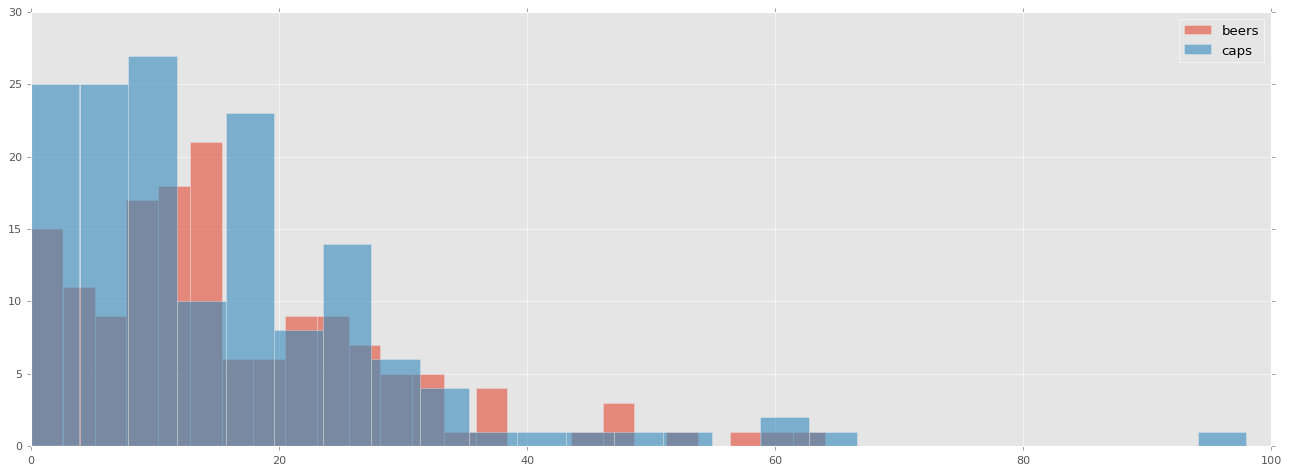

In [10]:
df_b['number of records'].hist(bins=25,alpha=0.6,label='beers')
df_c['number of records'].hist(bins=25,alpha=0.6,label='caps')
matplotlib.pyplot.legend()
print "Histogram of number of trials recorded by sim"

### How many students face table errors? (in caps only)

In [11]:
df_c['number of table errors'].astype(bool).sum()

12